In [1]:
!pip install imagehash -q

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imagehash
from PIL import Image
from tqdm import tqdm

# Set visualization style
plt.style.use('ggplot')
print("All EDA libraries imported!")

All EDA libraries imported!


# Load data

In [3]:

path_train = '/kaggle/input/datasets/deadcardassian/pm25vision/train/metadata.csv'
path_test = '/kaggle/input/datasets/deadcardassian/pm25vision/test/metadata.csv'

# Load and merge
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df = pd.concat([df_train, df_test], ignore_index=True)

print(f"Total images for Global EDA: {len(df)}")

Total images for Global EDA: 11219


# Check Class Balance

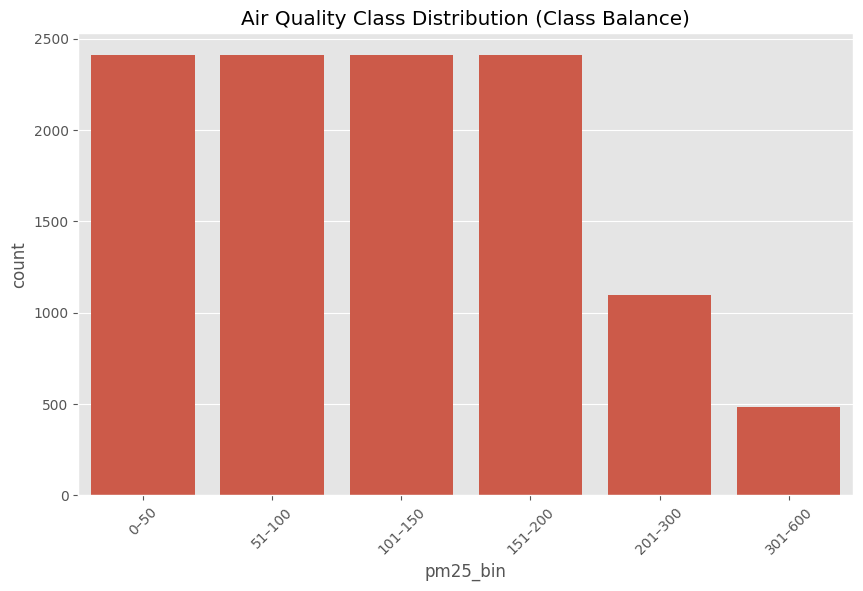

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='pm25_bin', order=df['pm25_bin'].value_counts().index)
plt.title('Air Quality Class Distribution (Class Balance)')
plt.xticks(rotation=45)
plt.show()

# Analyze Resolutions

In [5]:
def get_all_resolutions(df):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Scanning Resolutions"):
        path = f"/kaggle/input/datasets/deadcardassian/pm25vision/train/images/{row['filename']}"
        if not os.path.exists(path):
            path = f"/kaggle/input/datasets/deadcardassian/pm25vision/test/images/{row['filename']}"
            
        with Image.open(path) as img:
            w, h = img.size
            results.append({'width': w, 'height': h, 'aspect_ratio': w/h})
    return pd.DataFrame(results)

full_res_df = get_all_resolutions(df)
print("\nGlobal Resolution Statistics:")
print(full_res_df.describe())

Scanning Resolutions: 100%|██████████| 11219/11219 [00:52<00:00, 212.48it/s]


Global Resolution Statistics:
              width        height  aspect_ratio
count  11219.000000  11219.000000  11219.000000
mean    1023.217666    679.123095      1.540098
std       17.800644     99.711960      0.231033
min      320.000000    240.000000      0.667101
25%     1024.000000    576.000000      1.333333
50%     1024.000000    768.000000      1.333333
75%     1024.000000    768.000000      1.777778
max     1024.000000   1535.000000      2.939655
